Load modules

In [1]:
import gym
import numpy  as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

Environment

    Cart Pole

In [2]:
env = gym.make('CartPole-v1')
print(f'Statement space dim : {len(env.observation_space.bounded_below)}')
print(f'Action space dim : {env.action_space.n}')

Statement space dim : 4
Action space dim : 2


Hyper parameters

In [3]:
LR = 1e-4
GAMMA = 0.98
LAMBDA = 0.95
EPSILON = 0.1
K_EPOCH = 3
T_HORIZION = 20
N_EPOCH = 5000
BETA = 0.5

STATE_DIM = 4
ACTION_DIM = 2

Network

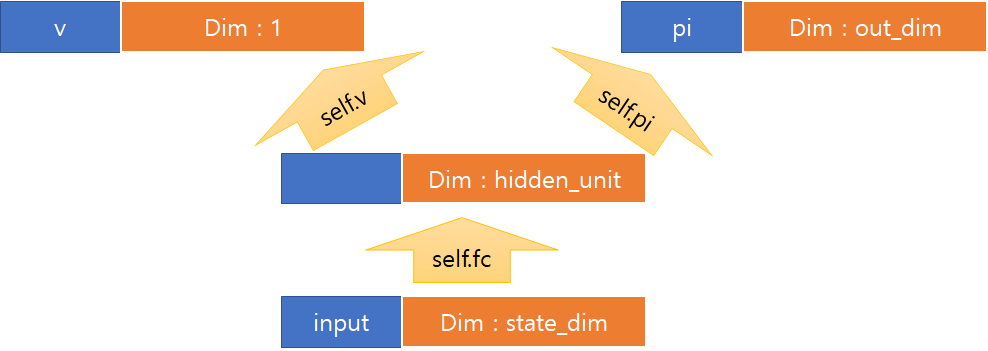

In [4]:
class Network(nn.Module):
  def __init__(self,
               state_dim, 
               hidden_unit,
               action_dim):
    super(Network, self).__init__()

    # arguments
    self.state_dim = state_dim
    self.hidden_unit = hidden_unit
    self.action_dim = ACTION_DIM

    # layers
    self.fc = nn.Linear(self.state_dim, self.hidden_unit)
    self.fc_v = nn.Linear(self.hidden_unit, 1)
    self.fc_pi = nn.Linear(self.hidden_unit, self.action_dim)

  def pi(self, x, soft_dim = 0):
    x = F.relu(self.fc(x))
    return F.softmax(self.fc_pi(x), soft_dim)

  def v(self, x):
    x = F.relu(self.fc(x))
    return F.relu(self.fc_v(x))

Util 

In [5]:
class Util:
  def __init__(self):
    self.data = []

  def append(self, item):
    self.data.append(item)

  def preprocess(self):
      state_lst, action_lst, reward_lst, next_state_lst, prob_lst, done_lst = [], [], [], [], [], []
      for transition in self.data:
        state, action, reward, next_state, prob, done = transition
        state_lst.append(state)
        action_lst.append([action])
        reward_lst.append([reward])
        next_state_lst.append(next_state)
        prob_lst.append([prob])
        done_mask = 0 if done else 1
        done_lst.append([done_mask])
      
      # list ---> tensor
      state_tensor = torch.tensor(state_lst, dtype=torch.float)
      action_tensor = torch.tensor(action_lst)
      reward_tensor = torch.tensor(reward_lst)
      next_state_tensor = torch.tensor(next_state_lst, dtype=torch.float)
      done_mask = torch.tensor(done_lst, dtype=torch.float)
      prob_tensor = torch.tensor(prob_lst)

      # initialize
      self.data = []

      return state_tensor, action_tensor, reward_tensor, \
            next_state_tensor, done_mask, prob_tensor

Training loop

In [6]:
class PPO(nn.Module):
  def __init__(self, env, net, lr):
    super(PPO, self).__init__()
    self.env = env
    self.net = net
    self.util = Util()
    self.lr = lr
    self.opt = optim.Adam(self.net.parameters(), lr = self.lr)
    self.loss_record = []

  def train(self, n_epoch = 20, k_epoch = 10, t_horizion = 20,
            Lambda = 0.9, gamma = 0.9, epsilon = 0.1, beta = 0.5):
    self.loss_record = []
    for epoch in range(n_epoch):
      # Initialize
      state = self.env.reset()
      done = False
      
      while not done:
        for _ in range(t_horizion):
          prob = net.pi(torch.from_numpy(state).float())
          action = Categorical(prob).sample().item()
          prob_a = prob[action].item()
          next_state, reward, done, info = self.env.step(action)
          self.util.append((state, action, reward, next_state, prob_a, done))
          state = next_state
          if done:
              break

        states, actions, rewards, next_states, dones, pi_olds = self.util.preprocess()

        #--- Update network k_epoch times ---#
        for _ in range(k_epoch):
          self.opt.zero_grad()
          #--- Caclulating td target and delta ---#
          td_targets = rewards + gamma*self.net.v(next_states)*dones
          deltas = (td_targets - self.net.v(states)).detach().numpy()
          #--- Caculating Advantage Function ---#
          A = 0.
          A_lst = []
          for delta in deltas[::-1]:
            A = gamma*Lambda*A+delta[0]
            A_lst.append([A])
          A_lst.reverse()
          A_tensor = torch.tensor(A_lst, dtype = torch.float)
          
          #--- Caculating ratio of pi ---#
          pi_new = self.net.pi(states, soft_dim = 1).gather(1, actions)
          ratio = torch.exp(torch.log(pi_new) - torch.log(pi_olds))

          #--- Surrogate Object ---#
          surrogate1 = ratio*A_tensor
          surrogate2 = torch.clamp(ratio, 1-epsilon, 1+epsilon)*A_tensor
          clipping_surrogate = torch.min(surrogate1, surrogate2)

          #--- KL penalty ---#
          kl_penalty = beta* F.smooth_l1_loss(self.net.v(states), td_targets.detach())

          #--- loss ---#
          loss = (-clipping_surrogate + kl_penalty).mean()
       
          #--- update ---#
          loss.backward()
          self.opt.step()

        # log
      loss = loss.detach().item()
      self.loss_record.append(loss)
      print(f'{epoch + 1} epoch  loss : {loss}')

Instances

In [7]:
# network
net = Network(state_dim = STATE_DIM,
              hidden_unit = 256,
              action_dim = ACTION_DIM)

# training loop
ppo = PPO(env = env, net = net, lr = LR)

Train

In [8]:
ppo.train(n_epoch = N_EPOCH, k_epoch = K_EPOCH, t_horizion = T_HORIZION,
          Lambda = LAMBDA, gamma = GAMMA, epsilon = EPSILON, beta = BETA)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1 epoch  loss : -0.7649229764938354
2 epoch  loss : -3.9290597438812256
3 epoch  loss : -5.908405303955078
4 epoch  loss : -4.551689624786377
5 epoch  loss : -5.389618396759033
6 epoch  loss : -6.129650115966797
7 epoch  loss : -4.844545364379883
8 epoch  loss : -4.514699459075928
9 epoch  loss : -5.6259846687316895
10 epoch  loss : -5.60214376449585
11 epoch  loss : -6.721556186676025
12 epoch  loss : -5.334306240081787
13 epoch  loss : -1.5720329284667969
14 epoch  loss : -6.018406391143799
15 epoch  loss : -4.985541820526123
16 epoch  loss : -4.672375202178955
17 epoch  loss : -6.433818817138672
18 epoch  loss : -0.8364043831825256
19 epoch  loss : -6.193859577178955
20 epoch  loss : -5.888335227966309
21 epoch  loss : -4.8375468254089355
22 epoch  loss : -4.622073650360107
23 epoch  loss : -4.310446262359619
24 epoch  loss : -3.63663387298584
25 epoch  loss : -6.134302139282227
26 epoch  loss : -4.847236156463623
27 epoch  loss : -5.8137140274047

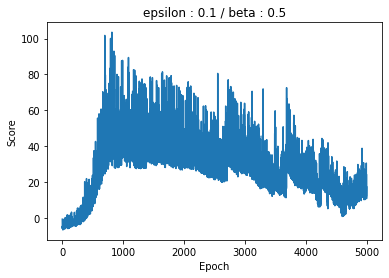

In [12]:
plt.title(f'epsilon : {EPSILON} / beta : {BETA}')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.plot(ppo.loss_record)
plt.show()